In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import joblib

import joblib

In [41]:
# 1. Load data from Excel view exported from SQL Server
file_path = r"C:\Users\91600\Downloads\Hospital_Prediction_Data.xlsx"
sheet_name = 'vw_ReadmissionData'

data = pd.read_excel(file_path, sheet_name=sheet_name)
print("Sample Data:\n", data.head())

Sample Data:
    gender             race      age  admission_type_id  \
0    Male        Caucasian  [30-40)                  1   
1  Female        Caucasian  [60-70)                  3   
2  Female  AfricanAmerican  [30-40)                  3   
3    Male        Caucasian  [60-70)                  3   
4  Female        Caucasian  [80-90)                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                         1                    7                 2   
1                         1                    1                 3   
2                         1                    1                 2   
3                        18                    1                 4   
4                         1                    7                 1   

   num_lab_procedures  num_procedures  num_medications  ...  number_inpatient  \
0                  42               0               12  ...                 0   
1                  39               3               10

In [43]:
# Encode categorical features
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'readmitted':  # Don't encode target here
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Encode target column manually
data['readmitted'] = data['readmitted'].map({'NO': 0, '<30': 1, '>30': 0})  # Only <30 is considered as readmitted



In [45]:
# Drop rows where target is still NaN after mapping
data = data.dropna(subset=['readmitted'])

# Define features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Step 1: Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [47]:
# Step 3: Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [48]:
# 🔹 7. Evaluate model
# Step 4: Evaluate on test set
y_pred = rf_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[16125  1273]
 [ 1953   260]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17398
           1       0.17      0.12      0.14      2213

    accuracy                           0.84     19611
   macro avg       0.53      0.52      0.52     19611
weighted avg       0.81      0.84      0.82     19611



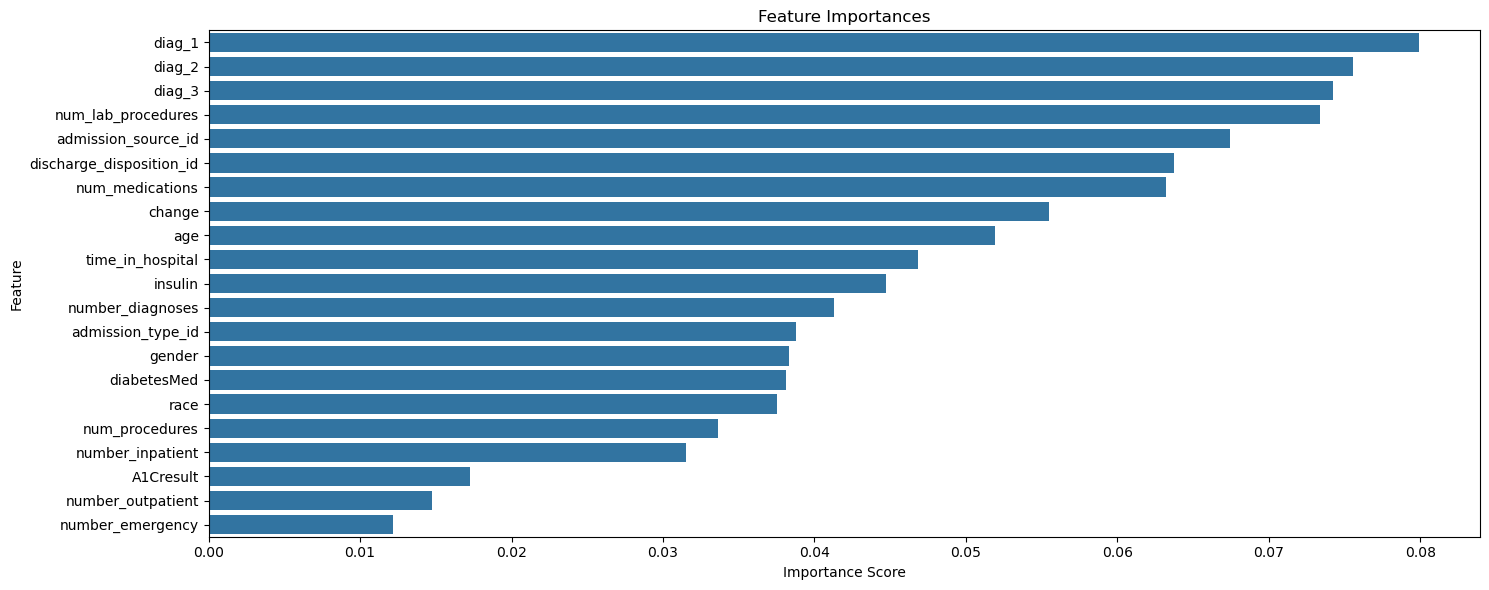

In [51]:
# 🔹 8. Plot Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [55]:
# 🔹 9. Save predictions to CSV
test_data_with_preds = X_test.copy()
test_data_with_preds['Predicted_Readmission'] = y_pred
test_data_with_preds.to_csv(r"C:\Users\91600\Downloads\ReadmissionPredictions.csv", index=False)